# Data prep

## This section is to prepare the data into the proper format for time series forecasting using TensorFlow

### There are many ways to architect a ML solution for TS forecasting - this one will use one of the most cutting edge methods LSTM (long/short term memory) models in a sequence to sequence architecture (seq2seq). 

Seq 2 seq is popular in many application surrounding machine translation (english to french, etc..). This makes sense as we will be taking a time series sequence of inputs to predict a time series output of predicted values

For this example, we will be using the Melbourne Daily min tempuratures dataset 
https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

to illustrate how this technique works. Note that there is only one feature and target/label here, but LSTMs take 3D shapes (n_observations, n_timesteps, n_features), and we will only be dealing with 1 element for the features



# Import and prep the data

Using TensorFlow backend.


,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


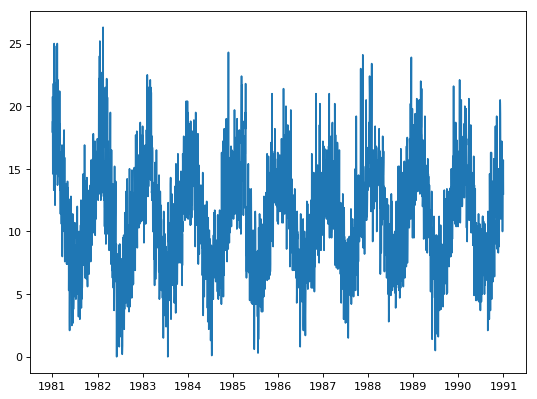

In [1]:
from matplotlib import pyplot as plt
import re
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import keras


%matplotlib inline

pandas_data = pd.read_csv('data/daily-minimum-temperatures-in-me.csv', sep=';', encoding='utf-8' )

columns = ['date', 'temp']

pandas_data.columns = columns

pandas_data['date'] = pd.to_datetime(pandas_data['date'])

pandas_data['temp'] = pandas_data['temp'].str.extract('(\d+.\d)', expand=False) #funky characters in data

pandas_data['temp'] = pandas_data['temp'].astype('float32')

pandas_data['temp'] = pandas_data['temp'].apply(lambda x: round(x,1)) #fp conversion created some noise
 
    
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(pandas_data['date'],pandas_data['temp'])


# pyplot.show
pandas_data.head(10)

In [2]:
pandas_np = pandas_data['temp'].values

dates = pandas_data['date'].values

nobs = pandas_np.shape[0]

train_obs = int(0.75 * nobs)

# we need to create a function that reshapes the data to have each observation as a time series
# and each prediction as a time series
# inspiration here: https://stackoverflow.com/questions/21229503/creating-an-numpy-matrix-with-a-lag

def lagLead4LSTM(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

lag = 90
lead = 30

x1  = lagLead4LSTM(pandas_np, lag)

x = x1[:-lead,] # get rid of last observations with no lags
    

In [3]:


pandas_np.shape, x1.shape, x.shape, pandas_np[lag-1:,].shape


((3650,), (3561, 90), (3531, 90), (3561,))

In [4]:
y = lagLead4LSTM(pandas_np[lag:,],lead) 

print(x[4], y[3]) 
#last element should be same as first (tommorows data = first datapoint in y)

"the shapes for x are: {} and the shapes for y are: {}".format(x.shape, y.shape)

[15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8
 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2 15.5 15.1 15.4 15.3
 18.8 21.9 19.9 16.6 16.8 14.6 17.1 25.  15.  13.7 13.9 18.3 22.  22.1
 21.2 18.4 16.6 16.1 15.7 16.6 16.5 14.4 14.4 18.5 16.9 17.5 21.2 17.8
 18.6 17.  16.  13.3 14.3 11.4 16.3 16.1 11.8 12.2 14.7 11.8 11.3 10.6
 11.7 14.2 11.2 16.9 16.7  8.1  8.   8.8 13.4 10.9 13.4 11.  15.  15.7
 14.5 15.8 16.7 16.8 17.5 17.1] [17.1 18.1 16.6 10.  14.9 15.9 13.   7.6 11.5 13.5 13.  13.3 12.1 12.4
 13.2 13.8 10.6  9.  10.   9.8 11.5  8.9  7.4  9.9  9.3  9.9  7.4  8.6
 11.9 14. ]


'the shapes for x are: (3531, 90) and the shapes for y are: (3531, 30)'

# The data is now in the shape for us to to a seq2seq model
## We are using the last 30 days to predict the next 7 days

First, we need to split the data and scale it on a 0-1

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(pandas_np.reshape(-1,1))

pandas_np_scaled = scaler.transform(pandas_np.reshape(-1,1))

pandas_np_scaled

trainN = int(0.75 * pandas_np_scaled.shape[0]) # will take only the first 75 percent days

trainRaw = pandas_np_scaled[:trainN,-1]

testRaw = pandas_np_scaled[trainN+1:,-1]

trainDates = dates[:trainN]

testDates = dates[trainN+1:]

In [6]:
"The number of train cases are {} days, test cases are {} days".format(trainRaw.shape[0], testRaw.shape[0])

'The number of train cases are 2737 days, test cases are 912 days'

In [7]:
#reapply the transform above now we are split and scaled
lag = 90
lead = 30

def reshapeDataXY(rawData, lag=lag, lead=lead):
    x = lagLead4LSTM(rawData, lag)
    x = x[:-lead,]
    xs1, xs2 = x.shape
    x = x.reshape(xs1, xs2, 1) #need 1 for the one feature
    y = lagLead4LSTM(rawData[lag:,],lead) 
    ys1, ys2 = y.shape
    y = y.reshape(ys1, ys2, 1)
    return x, y


xTrain, yTrain = reshapeDataXY(trainRaw)
xTest, yTest = reshapeDataXY(testRaw)

# create padded input target sequence
decodeY = np.zeros((yTrain.shape))
decodeY[:,1:,:] = yTrain[:,:-1,:]
# print(yTrain[2])
# print(decodeY[2])

In [8]:
print(xTrain.shape, yTrain.shape, decodeY.shape)

(2618, 90, 1) (2618, 30, 1) (2618, 30, 1)


# Now to setup the LSTM seq2seq model
from: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Here is an example of the architecture in the context of machine translation:

![](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

An excellent explanation of GRUs and LSTMs are here

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

![](https://cdn-images-1.medium.com/max/1600/1*VOXRGhOShoWWks6ouoDN3Q.gif)

In [9]:
# updatable plot
# a minimal example (sort of)
import keras


### custom metrics
def mse(y_true, y_pred):
    errorSQ = (y_pred - y_true)**2
    return errorSQ


def mae(y_true, y_pred):
    errorabs = abs(y_pred - y_true)
    return errorabs

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.mse = []
        self.mae = []
        
        self.fig = plt.figure()
        
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.mse.append(logs.get('mse'))
        self.mae.append(logs.get('mae'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.mse, label="MSE")
        plt.plot(self.x, self.mae, label="MAE")
        plt.legend()
        plt.show()
        plt.rcParams["figure.figsize"] = [16,9]
        
plot_losses = PlotLosses()

In [13]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, RNN
num_encoder_tokens = 1
num_decoder_tokens = 1

latent_dim = 16

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
\encoder = LSTM(latent_dim, return_state=True)
_, state_h1, state_c1 = encoder(encoder_outputs)
states = [state_h, ]



encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

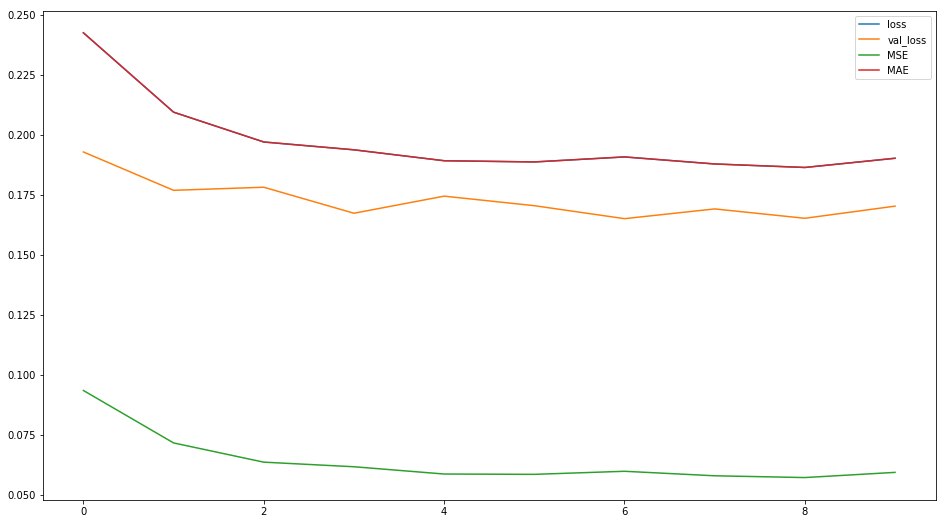

In [11]:
# Run training
from IPython.display import clear_output
import keras.backend as K


batch_size = 512
epochs = 10


#research - forced teaching (shifted by one input for decoder) does not perform well
decodeY = np.zeros(decodeY.shape)

learning_rate = 0.01
decay = 1e-7 # Learning rate decay
beta2 = .90

optimizer = keras.optimizers.Adam(lr=learning_rate, decay=decay, beta_2=beta2)

model.compile(optimizer=keras.optimizers.RMSprop(), loss='mean_absolute_error',
             metrics=[mse, mae])

model.fit([xTrain, decodeY], yTrain,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.05,
          callbacks=[plot_losses])

# Inference setup 


In [12]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []


for hidden_neurons in layers[::-1]:
    # Two states, two inputs 
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)


decoder_predict_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_6 (I

In [13]:
# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model=encoder_predict_model
            , decoder_predict_model=decoder_predict_model, num_steps_to_predict=lead):

    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1), dtype=float)


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=1)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)
        #decoder_input = output
        #print(output)

    return np.concatenate(y_predicted, axis=1)

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Actual, Predicted Values:
50.9 , 48.245884
43.16 , 48.59716
41.18 , 48.82948
49.1 , 48.99356
53.06 , 49.11845
48.56 , 49.220722
45.14 , 49.30974
49.46 , 49.390896
48.92 , 49.467518
50.0 , 49.54186
51.620000000000005 , 49.615612
51.8 , 49.690117
51.620000000000005 , 49.766434
46.4 , 49.84537
52.16 , 49.927483
45.5 , 50.013107
44.96 , 50.102364
55.76 , 50.195194
55.22 , 50.291397
48.92 , 50.39067
50.36 , 50.49262
49.1 , 50.596813
54.32 , 50.702797
50.36 , 50.810104
56.120000000000005 , 50.918297
52.879999999999995 , 51.02694
46.4 , 51.135643
48.2 , 51.24404
48.74 , 51.351818
56.3 , 51.458683

MAE: 2.8981189066569013


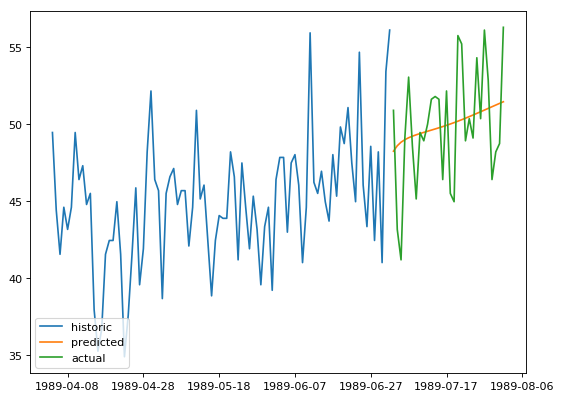

Actual, Predicted Values:
46.4 , 51.040363
46.58 , 51.29258
50.0 , 51.452984
47.3 , 51.55989
54.5 , 51.635532
59.0 , 51.692825
55.94 , 51.73938
51.8 , 51.779842
53.42 , 51.817215
46.94 , 51.853546
49.46 , 51.8903
52.34 , 51.928547
54.5 , 51.96905
48.92 , 52.01232
52.52 , 52.05866
55.76 , 52.108177
56.84 , 52.160843
60.8 , 52.216503
51.620000000000005 , 52.274925
53.42 , 52.335793
54.32 , 52.398777
55.76 , 52.463505
59.89999999999999 , 52.529613
70.88 , 52.596745
58.82 , 52.664555
57.92 , 52.73273
55.22 , 52.80098
55.58 , 52.86904
57.2 , 52.936687
64.22 , 53.003716

MAE: 4.212606475830078


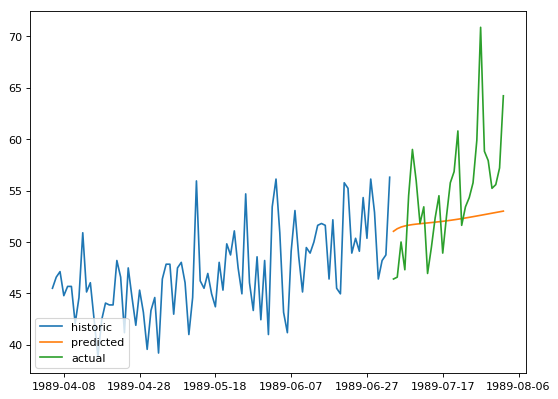

Actual, Predicted Values:
63.86 , 55.511772
61.34 , 55.74022
64.94 , 55.930984
56.660000000000004 , 56.088886
55.94 , 56.219444
51.08 , 56.32766
57.379999999999995 , 56.417595
60.8 , 56.492386
61.7 , 56.554333
57.379999999999995 , 56.605137
65.66 , 56.646065
61.16 , 56.678085
58.64 , 56.702007
54.68 , 56.718536
50.72 , 56.728317
53.96 , 56.731983
54.68 , 56.730145
53.78 , 56.723396
63.14 , 56.712322
61.519999999999996 , 56.69748
54.68 , 56.6794
54.14 , 56.658585
53.24 , 56.635483
53.6 , 56.610527
54.86 , 56.58409
61.519999999999996 , 56.556515
60.8 , 56.5281
55.94 , 56.4991
53.06 , 56.469753
50.72 , 56.44025

MAE: 3.810492894490559


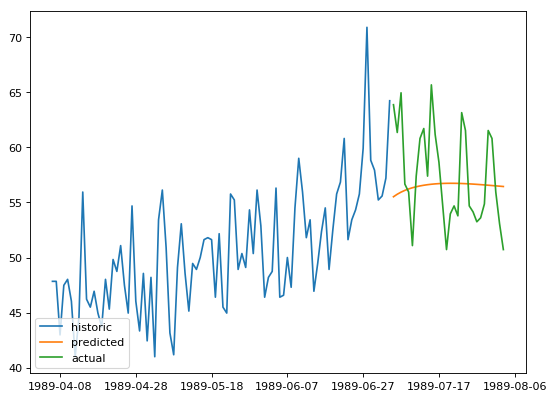

Actual, Predicted Values:
57.92 , 56.24257
54.86 , 56.146862
58.64 , 56.0578
55.94 , 55.970837
60.08 , 55.8855
58.099999999999994 , 55.802906
57.74 , 55.724457
59.540000000000006 , 55.651367
61.519999999999996 , 55.584446
58.64 , 55.524113
63.32 , 55.470463
65.84 , 55.423336
71.78 , 55.38241
66.2 , 55.347237
59.89999999999999 , 55.31734
60.440000000000005 , 55.2922
58.46 , 55.271305
51.26 , 55.254166
52.7 , 55.24033
59.0 , 55.229362
58.099999999999994 , 55.220886
58.099999999999994 , 55.214546
55.94 , 55.210037
57.74 , 55.20708
57.74 , 55.205437
68.9 , 55.20489
59.0 , 55.20526
62.78 , 55.20639
62.42 , 55.208138
62.42 , 55.21039

MAE: 4.893744277954103


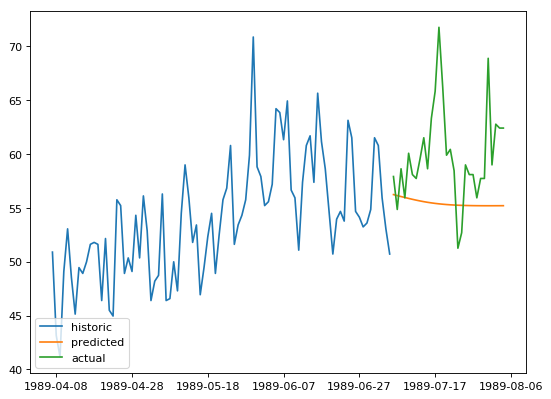

Actual, Predicted Values:
56.48 , 58.14314
61.519999999999996 , 58.127117
60.980000000000004 , 58.14173
53.6 , 58.164433
53.96 , 58.185795
58.64 , 58.20251
58.64 , 58.21381
57.92 , 58.21975
55.22 , 58.22051
56.120000000000005 , 58.216167
60.62 , 58.206726
60.980000000000004 , 58.192116
63.68 , 58.17231
60.08 , 58.14735
59.0 , 58.117363
55.4 , 58.08259
57.379999999999995 , 58.04335
63.14 , 58.000042
60.260000000000005 , 57.953117
65.48 , 57.903053
54.86 , 57.850338
57.2 , 57.795456
56.660000000000004 , 57.73887
61.34 , 57.68102
68.0 , 57.622307
62.6 , 57.563103
59.36 , 57.50372
61.7 , 57.44445
61.7 , 57.385544
63.14 , 57.327206

MAE: 3.160526611328125


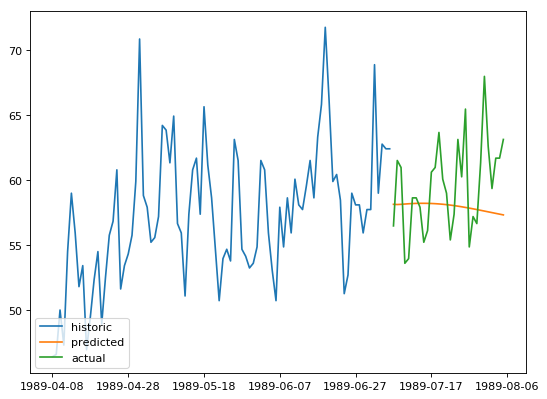

Actual, Predicted Values:
66.38 , 58.522213
66.74000000000001 , 58.51708
63.14 , 58.54223
66.2 , 58.573326
67.64 , 58.60047
66.74000000000001 , 58.620457
62.959999999999994 , 58.63282
57.56 , 58.63797
50.54 , 58.6364
55.4 , 58.628456
59.540000000000006 , 58.614357
59.0 , 58.59421
53.78 , 58.568142
48.56 , 58.536316
51.8 , 58.498966
59.0 , 58.456425
52.879999999999995 , 58.409096
52.879999999999995 , 58.357445
59.18 , 58.301994
59.0 , 58.24327
56.48 , 58.181812
54.5 , 58.11815
57.74 , 58.052788
60.8 , 57.986195
63.32 , 57.918804
62.42 , 57.851013
64.4 , 57.78316
69.08 , 57.71555
57.56 , 57.648445
51.620000000000005 , 57.582077

MAE: 4.6874161478678396


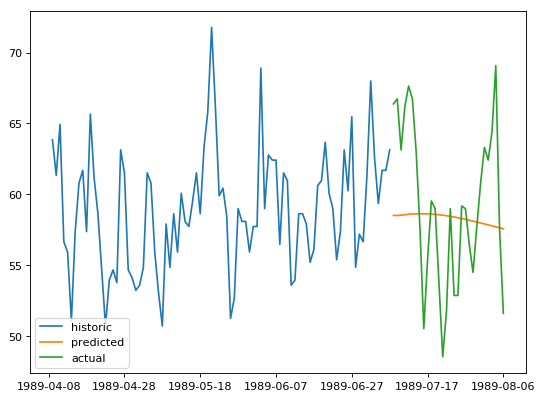

Actual, Predicted Values:
53.42 , 57.297398
55.94 , 57.331146
59.540000000000006 , 57.376133
58.46 , 57.41794
51.8 , 57.451454
53.96 , 57.475838
57.56 , 57.491867
62.6 , 57.500725
60.440000000000005 , 57.503468
59.36 , 57.5009
59.18 , 57.493565
58.46 , 57.481842
65.3 , 57.46601
61.519999999999996 , 57.446293
65.12 , 57.422924
59.18 , 57.396145
49.82 , 57.366234
50.36 , 57.33349
54.68 , 57.298233
55.76 , 57.260807
52.7 , 57.221535
56.84 , 57.180763
58.099999999999994 , 57.1388
58.46 , 57.095955
52.16 , 57.0525
54.86 , 57.00869
56.660000000000004 , 56.96476
52.7 , 56.9209
50.72 , 56.877293
48.02 , 56.834084

MAE: 3.46741850789388


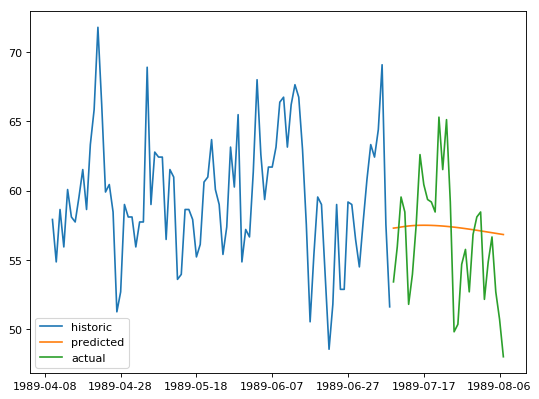

Actual, Predicted Values:
51.98 , 55.849342
49.1 , 55.672974
55.4 , 55.50205
57.02 , 55.336357
54.68 , 55.177612
57.74 , 55.027916
60.8 , 54.889084
55.94 , 54.76243
44.6 , 54.648727
40.82 , 54.548267
44.42 , 54.460968
56.660000000000004 , 54.38644
51.08 , 54.324074
54.14 , 54.27311
51.98 , 54.23269
50.36 , 54.201912
49.1 , 54.17984
48.02 , 54.16556
56.120000000000005 , 54.158176
48.379999999999995 , 54.156837
48.92 , 54.16075
47.66 , 54.169174
42.44 , 54.181435
40.1 , 54.196915
44.96 , 54.215065
50.0 , 54.235397
50.9 , 54.257477
51.26 , 54.28093
46.76 , 54.305428
42.980000000000004 , 54.33068

MAE: 5.446893763224284


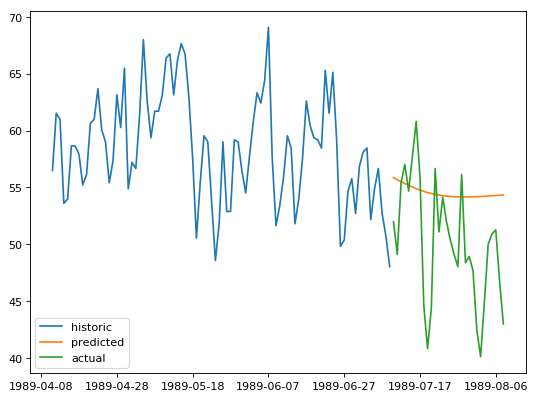

Actual, Predicted Values:
40.1 , 49.955452
42.980000000000004 , 50.001785
49.64 , 49.977943
49.46 , 49.922455
46.76 , 49.85579
47.120000000000005 , 49.788826
47.3 , 49.727287
50.72 , 49.67424
44.239999999999995 , 49.6314
42.8 , 49.599823
43.879999999999995 , 49.580177
46.04 , 49.57287
50.54 , 49.578056
44.96 , 49.595673
45.32 , 49.625404
52.52 , 49.666756
41.72 , 49.719025
39.92 , 49.781403
43.519999999999996 , 49.852966
48.74 , 49.932724
45.86 , 50.019676
46.58 , 50.11282
46.94 , 50.21118
48.379999999999995 , 50.313843
45.86 , 50.419937
51.08 , 50.528664
46.76 , 50.639313
46.22 , 50.75123
41.36 , 50.86384
42.620000000000005 , 50.976635

MAE: 4.3587252705891935


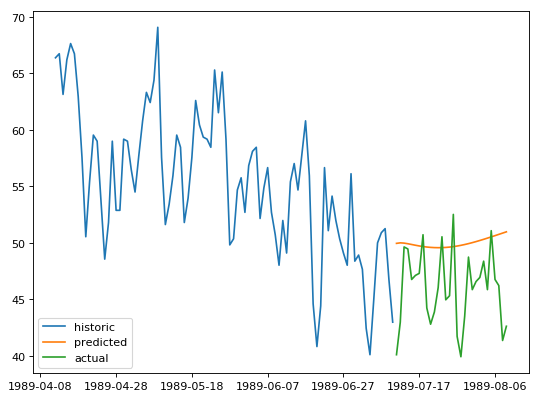

Actual, Predicted Values:
38.66 , 47.48821
42.08 , 47.770325
48.92 , 47.927605
45.32 , 48.01555
45.14 , 48.0655
45.86 , 48.095455
45.86 , 48.115814
48.74 , 48.13274
39.92 , 48.150177
42.26 , 48.170895
50.36 , 48.196976
50.36 , 48.230026
48.74 , 48.271236
41.72 , 48.32142
41.0 , 48.381012
45.68 , 48.45012
49.28 , 48.528557
50.72 , 48.61589
52.16 , 48.71151
48.379999999999995 , 48.81466
52.16 , 48.924503
44.239999999999995 , 49.040165
46.94 , 49.160767
49.46 , 49.28543
49.28 , 49.413338
49.64 , 49.54371
51.44 , 49.675827
48.56 , 49.809048
43.7 , 49.9428
46.58 , 50.076553

MAE: 3.067926305135091


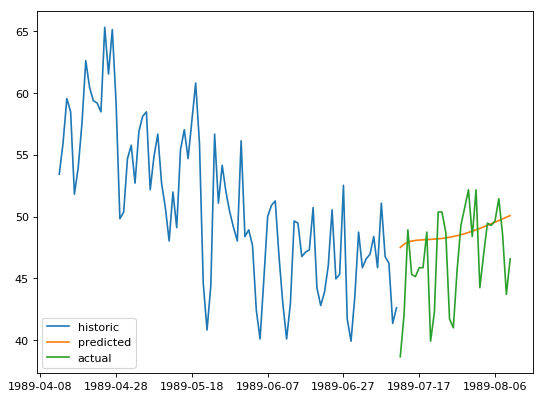

[2.8981189066569013, 4.212606475830078, 3.810492894490559, 4.893744277954103, 3.160526611328125, 4.6874161478678396, 3.46741850789388, 5.446893763224284, 4.3587252705891935, 3.067926305135091]
4.000386916097004


In [14]:
#print random plots for every 1000 steps
import matplotlib.dates as mdates

step = 30
offset = 365
prediction_time = 30


date_idx1 = trainN + 1 + offset - lag

date_idx2 = date_idx1 + lag + prediction_time

maeList=[]
for i in range(10):
    
    dates = pandas_data['date'][date_idx1+i: date_idx2+i]
    dates1 = pd.to_datetime(dates, unit='s')
    dates1 = [mdates.date2num(d) for d in dates1]

    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    test_line = i * step + offset

    xLine = xTest[test_line,:]
    yLine = yTest[test_line,:]

    xLine = xLine.reshape(1, lag, 1)
    yHat = predict(xLine, num_steps_to_predict=prediction_time)
    hist = np.vstack((xLine.reshape(lag, 1), -1*np.ones(yLine.shape)))
    hist = scaler.inverse_transform(hist)*9/5 + 32
    hist[hist == 32] = np.nan

    plt.plot(dates1, hist)
    preds = np.vstack((-1*np.ones((lag, 1)), yHat[0,:]))
    preds = scaler.inverse_transform(preds)*9/5 + 32
    preds[preds == 32] = np.nan

    plt.plot(dates1, preds)
    acts = np.vstack((-1*np.ones((lag, 1)),yLine))
    acts = scaler.inverse_transform(acts)*9/5 + 32
    acts[acts == 32] = np.nan

    plt.plot(dates1, acts)
    plt.legend(['historic', 'predicted', 'actual'], loc='lower left')
    ax = plt.axes()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    print("Actual, Predicted Values:")
    mae = 0
    
    for i, j in zip(yLine.flatten(), yHat.flatten()):
        i = scaler.inverse_transform(i)*9/5 + 32
        j = scaler.inverse_transform(j)*9/5 + 32
        i = i.flatten()[0]
        j = j.flatten()[0]
        print(i,",", j)
        mae += abs(i - j)
    mae = mae / yLine.shape[0]
    print()
    print("MAE: {}".format(mae))
    maeList.append(mae)
    plt.show()
print(maeList)
print(sum(maeList) / len(maeList))


In [15]:
encoder_predict_model.save('models/DEEP_LSTMencoder.h5')
decoder_predict_model.save('models/DEEP_LSTMdecoder.h5')

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer rnn_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_6:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_7:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'input_8:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
